# Single Column
This looks at where heat stress is peaked in single column experiments, and how this compares to the full dynamical case.

In [1]:
import copy
import sys
import os

from isca_tools.convection import potential_temp
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import numpy as np
import matplotlib.pyplot as plt
import numpy_indexed.index
import xarray as xr
import scipy.optimize
from tqdm.notebook import tqdm
from scipy import integrate
# Use custom matplotlib style for publishing
plt.style.use(os.environ['PWD']+'/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
import matplotlib
# matplotlib.rcParams['lines.linewidth'] = 1.2          # make lines bigger for presentation

In [2]:
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat
from isca_tools.utils.circulation import get_u_thermal
from isca_tools.utils.constants import g, R, radius_earth, rot_earth
from isca_tools.utils import area_weighting, annual_time_slice
from isca_tools.utils.ds_slicing import annual_mean, time_rolling
from isca_tools.convection.base import potential_temp

In [3]:
def get_angular_mom(u, lat, omega=rot_earth, radius=radius_earth):
    cos_lat = np.cos(np.deg2rad(lat))
    return (u+omega*radius*cos_lat)*radius_earth*cos_lat

def get_u_from_angular_mom(ang_mom, lat, omega=7.2921150e-05, radius=radius_earth):
    cos_lat = np.cos(np.deg2rad(lat))
    return ang_mom/radius_earth/cos_lat - omega*radius*cos_lat

In [4]:
# Load dataset - at surface and in free troposphere
use_time_start = 360*2
pressure_ft = 500               # Desired approximate pressure of free troposphere (hPa)
p_surface_approx = np.inf          # Desired approximate pressure of surface (hPa)

# Load dataset for
# exp_dir = 'rossbypalooza/lat_20/'
# exp_names = ['0_25', '0_5', '1', '2', '4']
# time_start = 100
# time_final = 9999999999999999
exp_dir = {'std': 'rossbypalooza/depth=20/all_nh/lat_10/',
           'col': 'rossbypalooza/depth=20/all_nh/lat_10/column/'}
exp_name = {'std': ['base', 'kappa=1_5', 'evap=0'],
            'col': ['base', 'kappa=1_5', 'evap=0']}
exp_dir_sc = 'rossbypalooza/depth=20/all_nh/lat_10/column/'
time_start = 3600
time_final = np.inf
smooth_ndays = 20       # take rolling average in time dimension over this many days


# only keep variables required to compute relative humidity and MSE
var_keep = {'std': ['temp', 'sphum', 'height', 't_surf', 'precipitation', 'ucomp', 'vcomp', 'omega']}
var_keep['col'] = [var for var in var_keep['std'] if var not in ['ucomp', 'vcomp', 'omega']]

namelist = isca_tools.load_namelist(exp_dir['std']+exp_name['std'][0])  # Need this for albedo_value
albedo = namelist['mixed_layer_nml']['albedo_value']
tau_sw = namelist['two_stream_gray_rad_nml']['atm_abs']
tau_lw = namelist['two_stream_gray_rad_nml']['odp']
try:
    omega = namelist['constants_nml']['omega']
except KeyError:
    omega = rot_earth  # default earth value

# Load in datasets
ds_base = {}
ds = {}
pbar = tqdm(total=len(exp_name['std']) + len(exp_name['col']))
for key in exp_dir:
    ds_base[key] = {}
    ds[key] = {}
    for key2 in exp_name[key]:
        ds_base[key][key2]  = isca_tools.load_dataset(exp_dir[key]+key2).sel(time=slice(time_start, time_final))[var_keep[key]]
        ds_base[key][key2]['mse_surf'] = moist_static_energy(ds_base[key][key2].temp.sel(pfull=np.inf, method='nearest'),
                                                        ds_base[key][key2].sphum.sel(pfull=np.inf, method='nearest'),
                                                        ds_base[key][key2].height.sel(pfull=np.inf, method='nearest'))
        ds_base[key][key2]['mse_sat'] = moist_static_energy(ds_base[key][key2].temp, sphum_sat(ds_base[key][key2].temp, ds_base[key][key2].pfull*100),
                                                            ds_base[key][key2].height)
        # # Get annual mean smoothed solution
        ds[key][key2] = annual_mean(ds_base[key][key2]).mean(dim='lon')
        if smooth_ndays > 1:
            ds[key][key2] = time_rolling(ds[key][key2], smooth_ndays)
        ds[key][key2] = ds[key][key2].load()
        pbar.update(1)

pbar.close()

# Sanity check that simulations are same
for var in ['time', 'lat', 'pfull']:
    for key_col in ds_base['col']:
        for key_std in ds_base['std']:
            if not np.array_equal(ds_base['col'][key_col][var].to_numpy(), ds_base['std'][key_std][var].to_numpy()):
                raise ValueError(f'ds_col_{key_col} and ds_std_{key_std}: {var} arrays do not match')


  0%|          | 0/6 [00:00<?, ?it/s]

/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:52: UserWarning: First month saved is 121 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:52: UserWarning: First month saved is 121 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:52: UserWarning: First month saved is 121 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')


In [5]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05
im_sz = 1.5

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']
omega_earth_multiple = '{:g}'.format(float('{:.2g}'.format(omega/rot_earth)))      # multiple of earths rotation rate

month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])
month_names = ['January','February','March','April','May','June','July','August','September','October','November','December']
n_days_year = ds['std']['base'].time.size

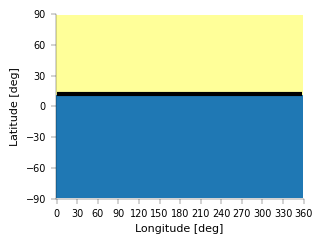

In [6]:
# Show where the land is
save_land_fig = False

job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir['std'], 'base', 'land.nc')
is_land_data = os.path.exists(land_file_name)
if is_land_data:
    fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
    isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
    lat_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[0]       # get the longitude coordinates of land
    lat_land_min = float(lat_land.min())
    lat_land_max = float(lat_land.max())
    lat_land_ind = np.where(ds['std']['base'].lat>=lat_land_min-0.5)[0]
    lat_land_ind = lat_land_ind[np.where(ds['std']['base'].lat[lat_land_ind]<=lat_land_max+0.5)[0]]
    if save_fig or save_land_fig:
        fig.savefig(f"/Users/joshduffield/Desktop/land_coords.pdf",
                    dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)
else:
    lat_land_min = None
    lat_land_max = None
    lat_land_ind = None

def show_land(ax, lat_land_min=lat_land_min, lat_land_max=lat_land_max, lat_ax='x', color_land='g', lw_land=4):
    if is_land_data:
        if not isinstance(ax, (list, np.ndarray)):
            raise ValueError(f'ax should be a list or numpy array, but given is {type(ax)}')
        for i in range(len(ax)):
            if lat_ax == 'x':
                var = ax[i].get_ylim()[0]
                xlim = ax[i].get_xlim()
                ax[i].hlines(var, lat_land_min, lat_land_max, color=color_land, lw=lw_land)
                ax[i].set_ylim(var, ax[i].get_ylim()[1])
                ax[i].set_xlim(xlim)
            elif lat_ax == 'y':
                var = ax[i].get_xlim()[0]
                ylim = ax[i].get_ylim()
                ax[i].vlines(var, lat_land_min, lat_land_max, color=color_land, lw=lw_land)
                ax[i].set_xlim(var, ax[i].get_xlim()[1])
                ax[i].set_ylim(ylim)
            else:
                raise ValueError(f'lat_ax must be either x or y, but {lat_ax} was given.')

## Amplification of max MSE relative to equator
Below I plot how the MSE amplification relative to the equator evolves throughout the year.

In [7]:
lat_eq_max = 5      # equatorial value is between +/- 5 degrees
def get_eq_value(dataset, lat_eq_max=lat_eq_max):
    return dataset.sel(lat=slice(-lat_eq_max, lat_eq_max)).mean(dim='lat')

In [8]:
# get maximum NH mse and latitude where it occurs
ind_ft = np.argmin(np.abs(ds['std']['base'].pfull.to_numpy() - pressure_ft))
ind_surf = np.argmin(np.abs(ds['std']['base'].pfull.to_numpy() - 99999999))
pressure_ft_actual = float(ds['std']['base'].pfull[ind_ft] * 100)
p_surface = float(ds['std']['base'].pfull[ind_surf] * 100)
mse_max = {key: {key2: np.zeros(n_days_year) for key2 in ds[key]} for key in ds}
mse_ft_sat_max = {key: {key2: np.zeros(n_days_year) for key2 in ds[key]} for key in ds}
lat_mse_max = {key: {key2: np.zeros(n_days_year) for key2 in ds[key]} for key in ds}
lat_mse_ft_sat_max = {key: {key2: np.zeros(n_days_year) for key2 in ds[key]} for key in ds}
lat_hemisphere = {'n': slice(lat_eq_max, 90), 's': slice(-90, -lat_eq_max)}
hemisphere_plot = 'n'
for key in ds:
    for key2 in ds[key]:
        mse_max[key][key2] = ds[key][key2].mse_surf.sel(lat=lat_hemisphere[hemisphere_plot]).max(dim='lat')
        mse_ft_sat_max[key][key2] = ds[key][key2].mse_sat.isel(pfull=ind_ft).sel(lat=lat_hemisphere[hemisphere_plot]).max(dim='lat')
        lat_mse_max[key][key2] = ds[key][key2].lat.sel(lat=lat_hemisphere[hemisphere_plot])[
            ds[key][key2].mse_surf.sel(lat=lat_hemisphere[hemisphere_plot]).argmax(dim='lat')]
        lat_mse_ft_sat_max[key][key2] = ds[key][key2].lat.sel(lat=lat_hemisphere[hemisphere_plot]
                                              )[ds[key][key2].mse_sat.isel(pfull=ind_ft).sel(lat=lat_hemisphere[hemisphere_plot]).argmax(dim='lat')]

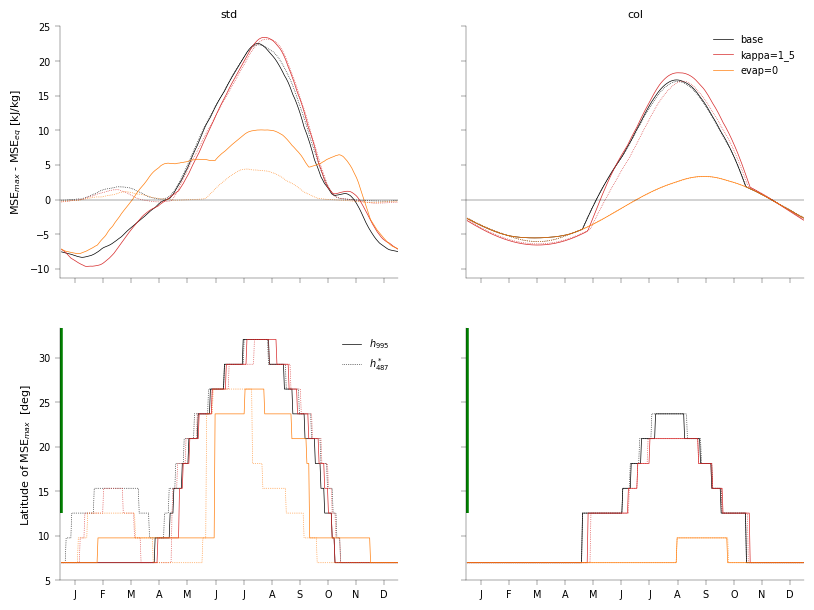

In [9]:
save_mse_amp_timeseries_fig = False
label_mse_surf = "$h_{"+f"{p_surface/100:.0f}"+"}$"
label_mse_ft = "$h^*_{"+f"{pressure_ft_actual/100:.0f}"+"}$"
color_exp = {'base': 'k', 'kappa=1_5': default_colors[3], 'evap=0': default_colors[1]}
linestyle_exp = {'std': None, 'col': '--'}
fig, ax = plt.subplots(2, 2, figsize=(im_sz*2*width['one_col'], im_sz*2*width['one_col']/ar), sharex=True, sharey='row')
for i, key in enumerate(ds):
    ax[0, i].set_title(key)
    for key2 in ds[key]:
        ax[0, i].plot(ds[key][key2].time, mse_max[key][key2] - get_eq_value(ds[key][key2].mse_surf),
                   color=color_exp[key2], label=key2)
        ax[0, i].plot(ds[key][key2].time, mse_ft_sat_max[key][key2] - get_eq_value(ds[key][key2].mse_sat.isel(pfull=ind_ft)),
                   color=color_exp[key2], linestyle=':')
        ax[1, i].plot(ds[key][key2].time, lat_mse_max[key][key2],
                   color=color_exp[key2], label=label_mse_surf if key2=='base' else None)
        ax[1, i].plot(ds[key][key2].time, lat_mse_ft_sat_max[key][key2],
                   color=color_exp[key2], linestyle=':', label=label_mse_ft if key2=='base' else None)
ax[0, 1].legend()
ax[1, 0].legend()
ax[0, 0].axhline(0, color='k', lw=ax_linewidth)
ax[0, 1].axhline(0, color='k', lw=ax_linewidth)
ax[0, 0].set_xticks(*month_ticks)
ax[0, 0].set_xlim(-1, n_days_year)
if hemisphere_plot == 'n':
    ax[1, 1].set_ylim(lat_eq_max, ax[1, 1].get_ylim()[1])
else:
    ax[1, 1].set_ylim(ax[1, 1].get_ylim()[0], -lat_eq_max)
ax[0, 0].set_ylabel('MSE$_{max}$ - MSE$_{eq}$ [kJ/kg]')
ax[1, 0].set_ylabel('Latitude of MSE$_{max}$  [deg]')
show_land(ax[1], lat_ax='y')
if save_mse_amp_timeseries_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/mse_amp_timeseries.pdf", 
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Surface Temperature
Below I repeat the above plot to show that the effect of $\Omega$ on MSE amplification is similar to that on max temperature.

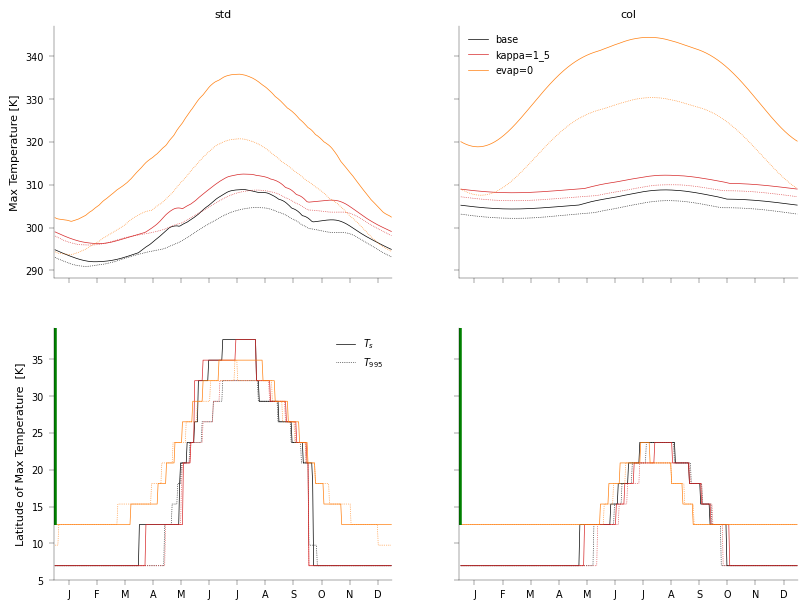

In [10]:
save_temp_max_fig = False
fig, ax = plt.subplots(2, 2, figsize=(im_sz*2*width['one_col'], im_sz*2*width['one_col']/ar), sharex=True, sharey='row')
for i, key in enumerate(ds):
    ax[0, i].set_title(key)
    for key2 in ds[key]:
        ax[0, i].plot(ds[key][key2].time, ds[key][key2].t_surf.sel(lat=lat_hemisphere[hemisphere_plot]).max(dim='lat'),
                   color=color_exp[key2], label=key2)
        ax[0, i].plot(ds[key][key2].time, ds[key][key2].temp.isel(pfull=ind_surf).sel(lat=lat_hemisphere[hemisphere_plot]).max(dim='lat'),
                   color=color_exp[key2], linestyle=':')
        ax[1, i].plot(ds[key][key2].time, ds[key][key2].lat.sel(lat=lat_hemisphere[hemisphere_plot])[
            ds[key][key2].t_surf.sel(lat=lat_hemisphere[hemisphere_plot]).argmax(dim='lat')],
                   color=color_exp[key2], label='$T_s$' if key2=='base' else None)
        ax[1, i].plot(ds[key][key2].time, ds[key][key2].lat.sel(lat=lat_hemisphere[hemisphere_plot])[
            ds[key][key2].temp.isel(pfull=ind_surf).sel(lat=lat_hemisphere[hemisphere_plot]).argmax(dim='lat')],
                   color=color_exp[key2], linestyle=':', label="$T_{"+f"{p_surface/100:.0f}"+"}$" if key2=='base' else None)
ax[0, 1].legend()
ax[1, 0].legend()
ax[0, 0].set_xticks(*month_ticks)
ax[0, 0].set_xlim(-1, n_days_year)
if hemisphere_plot == 'n':
    ax[1, 1].set_ylim(lat_eq_max, ax[1, 1].get_ylim()[1])
else:
    ax[1, 1].set_ylim(ax[1, 1].get_ylim()[0], -lat_eq_max)
ax[0, 0].set_ylabel('Max Temperature [K]')
ax[1, 0].set_ylabel('Latitude of Max Temperature  [K]')
show_land(ax[1], lat_ax='y')
if save_temp_max_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/mse_amp_timeseries.pdf", 
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [11]:
# Compute the time where NH MSE is max, typically also where MSE is furthest north
time_max_mse = {}
for key in ds:
    time_max_mse[key] = {}
    for key2 in ds[key]:
        ds_use = ds[key][key2].mse_surf.sel(lat=slice(lat_eq_max, np.inf))
        # Account for multiple maxima by taking median time
        time_max_mse[key][key2] = np.unravel_index(ds_use.argmax().item(), ds_use.shape)[0]

## Free Tropospheric Profile At Time Of Max Extent
Below I plot $T_{500}$ at the time of max NH $MSE_s$. This is to show difference between single column and standard configuration.

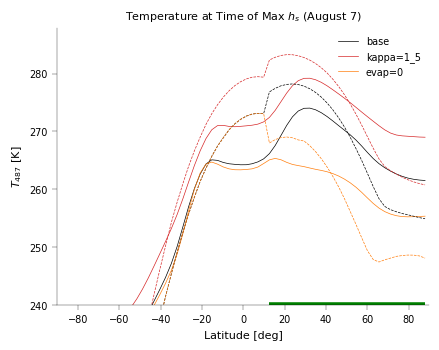

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
for key in ds:
    for key2 in ds[key]:
        ax.plot(ds[key][key2].lat, ds[key][key2].temp.sel(time=time_max_mse['std']['base'], method='nearest').isel(pfull=ind_ft),
                color=color_exp[key2], linestyle=linestyle_exp[key], label=key2 if key=='std' else None)
ax.legend()
ax.set_ylabel(label_mse_ft.replace('h^*', 'T') + ' [K]')
ax.set_xlabel('Latitude [deg]')
ax.set_xlim(-90, 90)
ax.set_ylim(240, ax.get_ylim()[1])

show_land([ax])
ax.set_title(f"Temperature at Time of Max $h_s$ "
             f"({month_names[int(np.floor(time_max_mse['std']['base']/30))]} {int(np.median(time_max_mse['std']['base'])%30+1)})");

In [217]:
def get_u_rce(temp_array, pressure_array, z_array, lat_array, ref_pressure_ind=0, omega_rot=rot_earth, radius=radius_earth):
    # temp is n_lat x n_pressure array where pressure is descending (first is near-surface pressure)
    # z_array is n_lat x n_pressure
    # Returns u at largest z value given
    lat_rad = np.deg2rad(lat_array)
    temp_pot = potential_temp(temp_array, pressure_array, pressure_array[ref_pressure_ind])
    temp_pot_ref = potential_temp(temp_array[:, ref_pressure_ind], pressure_array[ref_pressure_ind], pressure_array[ref_pressure_ind])
    temp_pot_integral = integrate.simpson(temp_pot, z_array, axis=1)
    temp_pot_integral_diff = np.gradient(temp_pot_integral, lat_rad, axis=0)
    return omega_rot * radius * np.cos(lat_rad) * (np.sqrt(1 - 1/np.cos(lat_rad)/np.sin(lat_rad) *
                                                           g/omega_rot**2/radius**2 * temp_pot_integral_diff/temp_pot_ref)-1)

# def get_u_rce(temp_array, pressure_array, z_array, lat_array, ref_pressure_ind=0, omega_rot=rot_earth, radius=radius_earth):
#     # Using l'Hopital rule - valid at equator if derivative in temp near 0
#     lat_rad = np.deg2rad(lat_array)
#     temp_pot = potential_temp(temp_array, pressure_array, pressure_array[ref_pressure_ind])
#     temp_pot_ref = potential_temp(temp_array[:, ref_pressure_ind], pressure_array[ref_pressure_ind], pressure_array[ref_pressure_ind])
#     temp_pot_integral = integrate.simps(temp_pot, z_array, axis=1)
#     temp_pot_integral_diff = np.gradient(np.gradient(temp_pot_integral, lat_rad, axis=0), lat_rad, axis=0)
#     return omega_rot * radius * (np.sqrt(1 - g/omega_rot**2/radius**2 * temp_pot_integral_diff/temp_pot_ref)-1)

pressure_u_plot = 300
time_u_plot = time_max_mse['std']['base']
u_plot = {key: {'actual': 0, 'rce': 0, 'ang_mom': 0} for key in ds['std']}
ang_mom_plot = {key: {'actual': 0, 'rce': 0, 'ang_mom': 0} for key in ds['std']}
u_plot_col_rce = {key: 0 for key in ds['col']}
ang_mom_plot_col_rce = {key: 0 for key in ds['col']}
for key in ds['std']:
    ds_use = ds['std'][key].isel(time=time_u_plot).sel(pfull=slice(pressure_u_plot, np.inf))
    u_plot[key]['actual'] = ds_use.ucomp.sel(pfull=0, method='nearest')
    u_plot[key]['rce'] = get_u_rce(ds_use.temp.to_numpy().transpose()[:, ::-1],
                              ds_use.pfull.to_numpy()[::-1]*100, ds_use.height.to_numpy().transpose()[:, ::-1],
                              ds_use.lat.to_numpy())
    ang_mom_plot[key]['actual'] = get_angular_mom(u_plot[key]['actual'], ds_use.lat)
    ang_mom_plot[key]['rce'] = get_angular_mom(u_plot[key]['rce'], ds_use.lat)
    # Two choices for ang_mom - either equatorial value, or first value where u=0 in NH
    ang_mom_plot[key]['ang_mom'] = get_eq_value(ang_mom_plot[key]['actual'])
    # ang_mom_plot[key]['ang_mom'] = ang_mom_plot[key]['actual'].where(
    #     np.logical_and(u_plot[key]['actual']>0,ang_mom_plot[key]['actual'].lat>lat_eq_max), drop=True)[0]
    u_plot[key]['ang_mom'] = get_u_from_angular_mom(ang_mom_plot[key]['ang_mom'], ds_use.lat)

    ds_use = ds['col'][key].isel(time=time_u_plot).sel(pfull=slice(pressure_u_plot, np.inf))
    u_plot_col_rce[key] = get_u_rce(ds_use.temp.to_numpy().transpose()[:, ::-1],
                          ds_use.pfull.to_numpy()[::-1]*100, ds_use.height.to_numpy().transpose()[:, ::-1],
                          ds_use.lat.to_numpy())
    ang_mom_plot_col_rce[key] = get_angular_mom(u_plot_col_rce[key], ds_use.lat)


# ds['std']['evap=0'].ucomp.isel(time=time_max_mse['std']['base']).sel(pfull=300, method='nearest').plot(ax=ax)
# get_u_from_angular_mom(ang_mom_300.sel(lat=0, method='nearest'), ds_use.lat).plot(ax=ax)
# ax.set_ylim(-100, 100)
# show_land([ax])

/var/folders/7_/l8blmzys4m95r6r44gy_r4gh0000gn/T/ipykernel_39309/3966107793.py:10: RuntimeWarning: invalid value encountered in sqrt
  return omega_rot * radius * np.cos(lat_rad) * (np.sqrt(1 - 1/np.cos(lat_rad)/np.sin(lat_rad) *
/var/folders/7_/l8blmzys4m95r6r44gy_r4gh0000gn/T/ipykernel_39309/3966107793.py:10: RuntimeWarning: invalid value encountered in sqrt
  return omega_rot * radius * np.cos(lat_rad) * (np.sqrt(1 - 1/np.cos(lat_rad)/np.sin(lat_rad) *


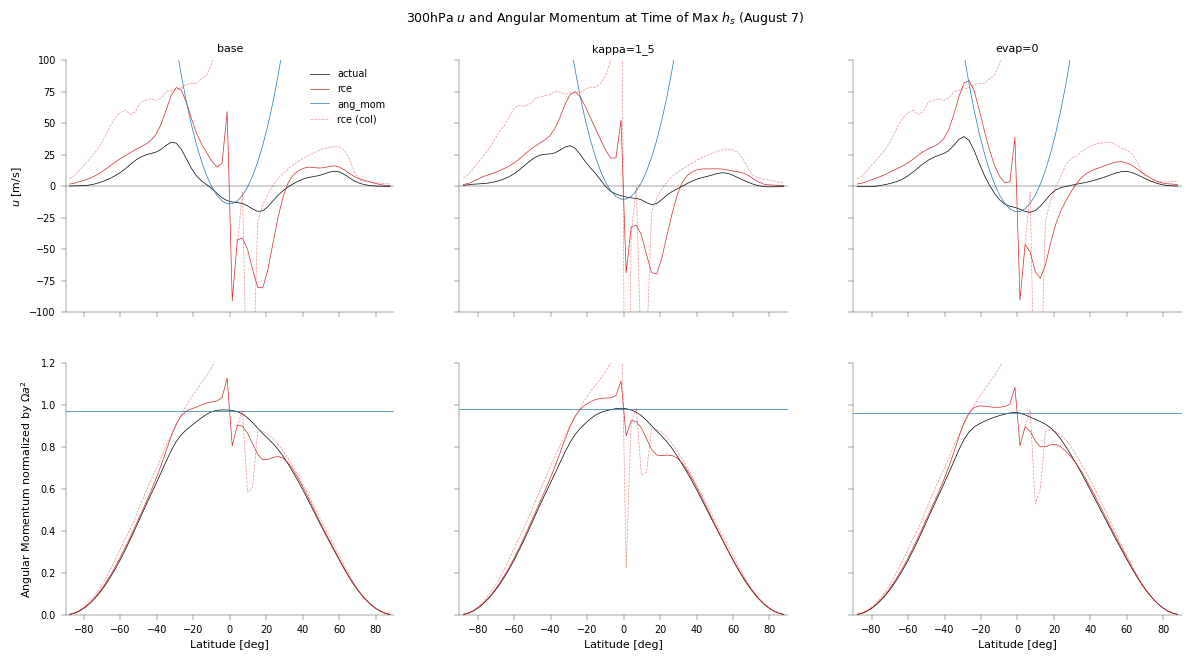

In [218]:
color_u_plot = {'actual': 'k', 'rce': default_colors[3], 'ang_mom': default_colors[0]}
fig, ax = plt.subplots(2, len(exp_name['std']), figsize=(3*im_sz*width['one_col'], 2*im_sz*width['one_col']/ar), sharex=True, sharey='row')
for i, key in enumerate(ds['std']):
    for key2 in u_plot[key]:
        ax[0, i].plot(ds['std']['base'].lat, u_plot[key][key2], color=color_u_plot[key2], label=key2)
        if key2 == 'ang_mom':
            ax[1, i].axhline(ang_mom_plot[key][key2]/rot_earth/radius_earth**2, color=color_u_plot[key2])
        else:
            ax[1, i].plot(ds['std']['base'].lat, ang_mom_plot[key][key2]/rot_earth/radius_earth**2, color=color_u_plot[key2])
    ax[0, i].plot(ds['std']['base'].lat, u_plot_col_rce[key], color=color_u_plot['rce'],
                  linestyle=linestyle_exp['col'], label='rce (col)', alpha=0.5)
    ax[1, i].plot(ds['std']['base'].lat, ang_mom_plot_col_rce[key]/rot_earth/radius_earth**2,
                  color=color_u_plot['rce'], linestyle=linestyle_exp['col'], alpha=0.5)
    ax[0, i].axhline(0, color='k', lw=ax_linewidth)
    ax[0, 0].legend()
    ax[0, i].set_title(key)
    ax[1, i].set_xlabel('Latitude [deg]')
ax[0, 0].set_xlim(-90, 90)
ax[0, 0].set_ylim(-100, 100)
ax[1, 0].set_ylim(0, 1.2)
ax[0, 0].set_ylabel('$u$ [m/s]')
ax[1, 0].set_ylabel('Angular Momentum normalized by $\Omega a^2$')
fig.suptitle(f"{pressure_u_plot}hPa $u$ and Angular Momentum at Time of Max $h_s$ "
             f"({month_names[int(np.floor(time_max_mse['std']['base']/30))]} {int(np.median(time_max_mse['std']['base'])%30+1)})",
             fontsize=9, y=0.95)
plt.show()

## Seasonal Evolution of temperature amplification
Below, I plot how the temperature amplification develops with time, both for the standard and column configuration.
It seems that in NH summer, the hottest temperature develops in a similar way to how it develops in the single column model.
I think that the amplitude of the escalation is larger, simply because you get wind feedbacks and
advection influencing relative humidity and temperature disequilibrium in the std configuration.

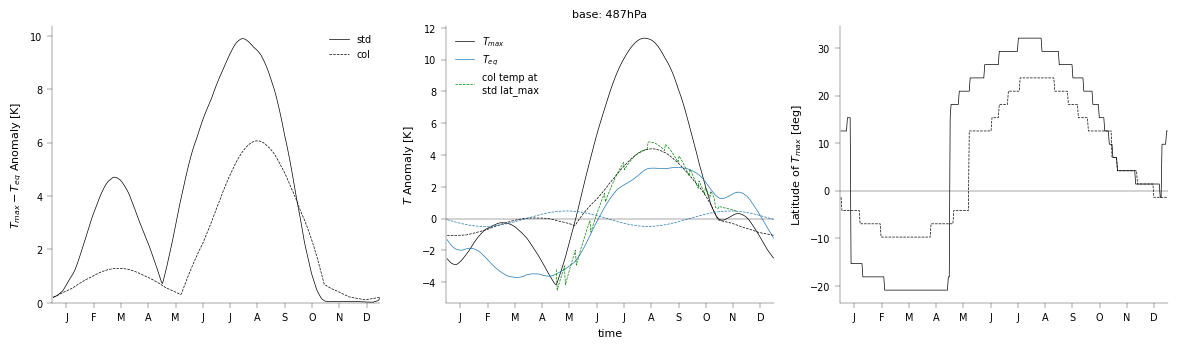

In [294]:
def get_anom(var):
    return var - np.median(var)

key_plot = 'base'
ind_pressure_plot = ind_ft * 1
# ind_pressure_plot = -1
fig, ax = plt.subplots(1, 3, figsize=(3*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True)

for key in ds:
    ax[0].plot(ds[key][key_plot].time, (ds[key][key_plot].temp.isel(pfull=ind_pressure_plot).max(dim='lat') -
                                          get_eq_value(ds[key][key_plot].temp.isel(pfull=ind_pressure_plot))),
               color='k', linestyle=linestyle_exp[key], label=key)
    ax[1].plot(ds[key][key_plot].time, get_anom(ds[key][key_plot].temp.isel(pfull=ind_pressure_plot).max(dim='lat')), color='k',
           linestyle=linestyle_exp[key], label='$T_{max}$' if key == 'std' else None)
    ax[1].plot(ds[key][key_plot].time, get_anom(get_eq_value(ds[key][key_plot].temp.isel(pfull=ind_pressure_plot))), color=default_colors[0],
               linestyle=linestyle_exp[key], label='$T_{eq}$' if key == 'std' else None)
    ax[2].plot(ds[key][key_plot].time, ds[key][key_plot].lat[ds[key][key_plot].temp.isel(pfull=ind_pressure_plot).argmax(dim='lat')], color='k',
           linestyle=linestyle_exp[key])
get_anom(ds['col'][key_plot].temp.isel(pfull=ind_pressure_plot)[:, ds['std'][key_plot].temp.isel(pfull=ind_pressure_plot).argmax(dim='lat')]
         ).sel(time=slice(120, 320)).plot(ax=ax[1], color='g', linestyle=linestyle_exp['col'], label='col temp at\nstd lat_max')
ax[0].legend()
ax[1].legend()
ax[0].set_xticks(*month_ticks)
ax[0].set_xlim(-1, n_days_year)
ax[0].set_ylim(0, ax[0].get_ylim()[1])
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[2].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_ylabel('$T_{max} - T_{eq}$ Anomaly [K]')
ax[1].set_ylabel('$T$ Anomaly [K]')
ax[2].set_ylabel('Latitude of $T_{max}$ [deg]')
ax[1].set_title("{}: {:.0f}hPa".format(key_plot, float(ds['std'][key_plot].pfull[ind_pressure_plot])))
plt.show()

(-20.0, 20.0)

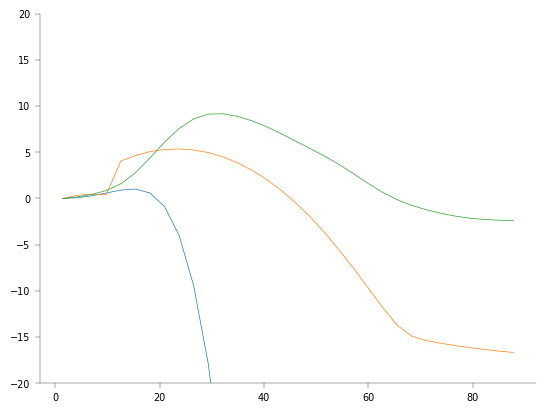

In [224]:
# Playing around with plotting temperature profile from wind profile assuming thermal wind
# Complicated as can only get a height or pressure average
# Also, the ang_mom profile above is based on equatorial angular momentum. Peak in temperature from this profile is where u=0, so very low latitude
# and small.
def get_temp_from_u_thermal(u, u_surf, lat_array, omega_rot=rot_earth, radius=radius_earth):
    # u is n_lat array of wind at pressure level p
    # returns pressure averaged temperature i.e. integ_p_s^p (temp/p) dp
    lat_rad = np.deg2rad(lat_array)
    f_coriolis = 2 * omega_rot * np.sin(lat_rad)
    return -f_coriolis * radius / R * np.asarray([integrate.simps(u[:i+1] - u_surf[:i+1], lat_rad[:i+1], axis=0) for i in range(len(lat_rad))])

a = get_temp_from_u_thermal(u_plot['base']['actual'].sel(lat=slice(0, np.inf)).to_numpy()[::-1],
                            ds['std']['base'].ucomp.sel(lat=slice(0, np.inf)).sel(pfull=np.inf, method='nearest').isel(time=time_u_plot).to_numpy()[::-1],
                            ds['std']['base'].lat.sel(lat=slice(0, np.inf)).to_numpy()[::-1])
a2 = get_temp_from_u_thermal(u_plot['base']['ang_mom'].sel(lat=slice(0, np.inf)).to_numpy(),
                            ds['std']['base'].ucomp.sel(lat=slice(0, np.inf)).sel(pfull=np.inf, method='nearest').isel(time=time_u_plot).to_numpy(),
                            ds['std']['base'].lat.sel(lat=slice(0, np.inf)).to_numpy())
ds_use = ds['col']['base'].isel(time=time_u_plot).sel(pfull=slice(pressure_u_plot, np.inf)).sel(lat=slice(0, np.inf))
a3 = integrate.simpson(ds_use.temp[::-1]/(ds_use.pfull[::-1]*100), ds_use.pfull[::-1]*100, axis=0)
a3 = -(a3 - a3[0])
# plt.plot(ds['std']['base'].lat.sel(lat=slice(0, np.inf)).to_numpy(), a[::-1])
plt.plot(ds['std']['base'].lat.sel(lat=slice(0, np.inf)).to_numpy(), a2)
plt.plot(ds['std']['base'].lat.sel(lat=slice(0, np.inf)).to_numpy(), a3)
ds_use = ds['std']['base'].isel(time=time_u_plot).sel(pfull=slice(pressure_u_plot, np.inf)).sel(lat=slice(0, np.inf))
a3 = integrate.simpson(ds_use.temp[::-1]/(ds_use.pfull[::-1]*100), ds_use.pfull[::-1]*100, axis=0)
a3 = -(a3 - a3[0])
plt.plot(ds['std']['base'].lat.sel(lat=slice(0, np.inf)).to_numpy(), a3)
plt.ylim(-20, 20)

(0.0, 30.0)

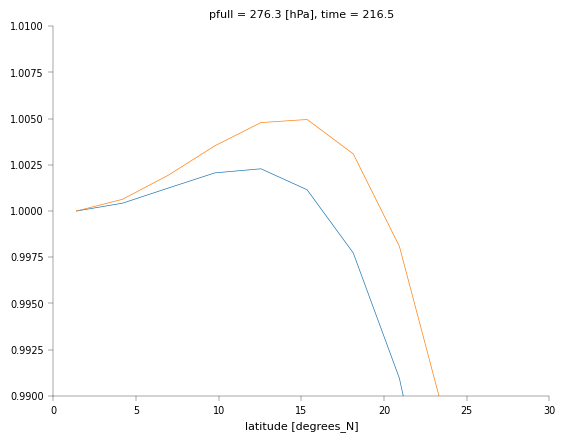

In [125]:
def get_temp_from_u_thermal(u, lat_array, z, omega_rot=rot_earth, radius=radius_earth):
    # u is n_lat array of wind at height z
    # returns non-dimensional height averaged temperature i.e. 1/z/theta_0 integ_0^z (theta) dz or 1/z integ_0^z ln(temp) dz
    lat_rad = np.deg2rad(lat_array)
    f_coriolis = 2 * omega_rot * np.sin(lat_rad)
    return -f_coriolis * radius / g / z * np.asarray([integrate.simps(u[:i+1], lat_rad[:i+1], axis=0) for i in range(len(lat_rad))])

# for key in ds['std']:
#     ds_use =
#     temp_integ_plot = {'actual': }

a = get_temp_from_u_thermal(u_plot['base']['ang_mom'].sel(lat=slice(0, np.inf)), ds['std']['base'].lat.sel(lat=slice(0, np.inf)),
                        ds['std']['base'].height.sel(pfull=pressure_u_plot, method='nearest').isel(time=time_u_plot).sel(lat=slice(0, np.inf)))
(a+1).plot()
a2 = get_temp_from_u_thermal(u_plot['evap=0']['ang_mom'].sel(lat=slice(0, np.inf)), ds['std']['base'].lat.sel(lat=slice(0, np.inf)),
                        ds['std']['evap=0'].height.sel(pfull=pressure_u_plot, method='nearest').isel(time=time_u_plot).sel(lat=slice(0, np.inf)))
(a2+1).plot()
plt.ylim(0.99, 1.01)
plt.xlim(0, 30)

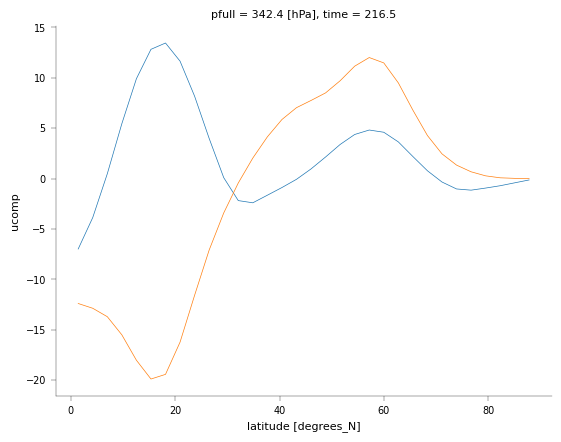

In [145]:
ds_use.ucomp.sel(pfull=np.inf, method='nearest').sel(lat=slice(0, np.inf)).plot()
ds_use.ucomp.sel(pfull=0, method='nearest').sel(lat=slice(0, np.inf)).plot()

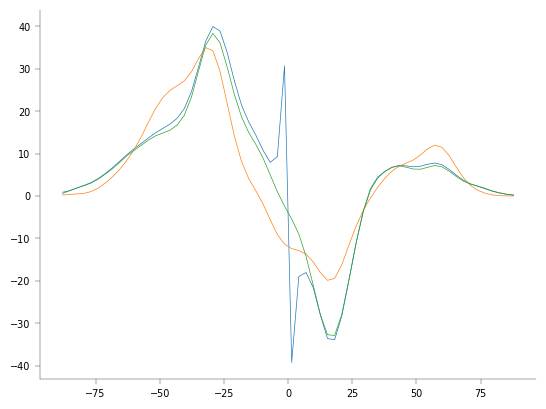

In [151]:
ds_use = ds['std'][key].isel(time=time_u_plot).sel(pfull=slice(pressure_u_plot, np.inf))
a4 = get_u_thermal(ds_use.temp[::-1], ds_use.pfull[::-1], ds_use.lat)
plt.plot(ds_use.lat, a4)
plt.plot(ds_use.lat, ds_use.ucomp[0])
plt.plot(ds_use.lat, ds_use.ucomp[0] - ds_use.ucomp[-1])

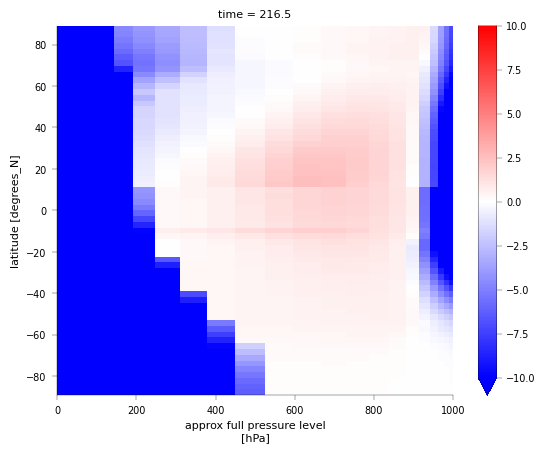

In [55]:
(ds['col']['base'].mse_surf - ds['col']['base'].mse_sat).isel(time=time_u_plot).plot(vmin=-10, vmax=10, cmap='bwr')

(0.0, 10000.0)

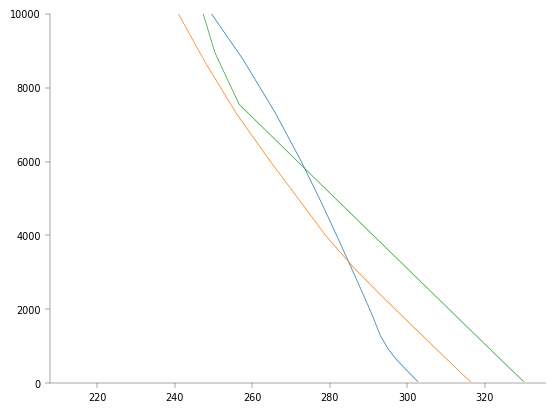

In [65]:
plt.plot(ds['std']['base'].temp.isel(time=time_u_plot).sel(lat=25, method='nearest'), ds['std']['base'].height.isel(time=time_u_plot).sel(lat=25, method='nearest'))
plt.plot(ds['std']['evap=0'].temp.isel(time=time_u_plot).sel(lat=25, method='nearest'), ds['std']['evap=0'].height.isel(time=time_u_plot).sel(lat=25, method='nearest'))
plt.plot(ds['col']['evap=0'].temp.isel(time=time_u_plot).sel(lat=25, method='nearest'), ds['col']['evap=0'].height.isel(time=time_u_plot).sel(lat=25, method='nearest'))
plt.ylim(0, 10000)

(-20.0, 20.0)

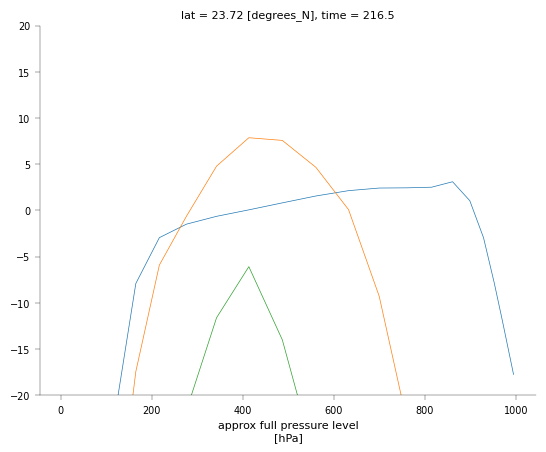

In [60]:
(ds['std']['base'].mse_surf - ds['std']['base'].mse_sat).isel(time=time_u_plot).sel(lat=25, method='nearest').plot()
(ds['std']['evap=0'].mse_surf - ds['std']['evap=0'].mse_sat).isel(time=time_u_plot).sel(lat=25, method='nearest').plot()
(ds['col']['evap=0'].mse_surf - ds['col']['evap=0'].mse_sat).isel(time=time_u_plot).sel(lat=25, method='nearest').plot()
plt.ylim(-20, 20)